# México-Videos-AI

## ETL (Extract)

Vamos a realizar una predicción de datos de visualización de videos de YouTube en México a partir de un Dataset disponible en Kaggle. Este conjunto de datos contiene información detallada de los videos en tendencia, incluyendo variables como título, canal, categoría, fecha de publicación, etiquetas, número de visualizaciones, likes, dislikes y comentarios, entre otros. 

El objetivo del análisis es identificar patrones y comportamientos dentro del contenido que se vuelve popular en México, para después entrenar un modelo predictivo que permita estimar la cantidad de visualizaciones que un video podría alcanzar en función de sus características. En este caso.

In [1]:
import pandas as pd

SHEET_ID = "1B8uxNo2htsjObyleHLZJrhtF_RmtSFp1qG_pk7LCNYY"
GID = "272605901" 

csv_url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={GID}"

df = pd.read_csv(csv_url)
print(df.shape)
print(df.head())

(40451, 16)
      video_id trending_date  \
0  SbOwzAl9ZfQ      17.14.11   
1  klOV6Xh-DnI      17.14.11   
2  6L2ZF7Qzsbk      17.14.11   
3  hcY52MFWMDM      17.14.11   
4  _OXDcGPVAa4      17.14.11   

                                               title  \
0                      Capítulo 12 | MasterChef 2017   
1  ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...   
2             LOUIS CKAGÓ - EL PULSO DE LA REPÚBLICA   
3   Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017   
4           DOG HACKS | MUSAS LESSLIE LOS POLINESIOS   

              channel_title  category_id              publish_time  \
0           MasterChef 2017           24  2017-11-13T06:06:22.000Z   
1  Micky Contreras Martinez           22  2017-11-13T05:11:58.000Z   
2  El Pulso De La República           25  2017-11-13T17:00:02.000Z   
3                  Casanare           25  2017-11-13T03:47:10.000Z   
4                     Musas           26  2017-11-13T19:17:48.000Z   

                                     

### Estadísticas descriptivas del dataset

Primero queremos entender cómo es que está compuesto nuestro Dataset.

In [2]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,40451.000000,4.045100e+04,4.045100e+04,4.045100e+04,40451.000000
mean,21.003140,3.423820e+05,1.586184e+04,7.471604e+02,2039.660008
std,5.878995,1.714691e+06,8.108987e+04,1.095358e+04,13938.031797
min,1.000000,1.570000e+02,0.000000e+00,0.000000e+00,0.000000
25%,20.000000,1.681300e+04,2.990000e+02,1.700000e+01,42.000000
50%,24.000000,5.697300e+04,1.246000e+03,6.300000e+01,196.000000
75%,24.000000,2.068940e+05,7.226000e+03,2.670000e+02,885.000000
max,43.000000,1.009124e+08,4.470923e+06,1.353667e+06,905925.000000


- Exploratory Data Analysis

Verificar que todas las columnas contengan datos del mismo tipo, asegurando la consistencia dentro de cada columna

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40451 entries, 0 to 40450
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40451 non-null  object
 1   trending_date           40451 non-null  object
 2   title                   40451 non-null  object
 3   channel_title           40451 non-null  object
 4   category_id             40451 non-null  int64 
 5   publish_time            40451 non-null  object
 6   tags                    40451 non-null  object
 7   views                   40451 non-null  int64 
 8   likes                   40451 non-null  int64 
 9   dislikes                40451 non-null  int64 
 10  comment_count           40451 non-null  int64 
 11  thumbnail_link          40451 non-null  object
 12  comments_disabled       40451 non-null  bool  
 13  ratings_disabled        40451 non-null  bool  
 14  video_error_or_removed  40451 non-null  bool  
 15  de

- Revisar la forma del dataset

In [4]:
df.shape

(40451, 16)

- Histogramas (exploratory data analysis)

Graficamos histogramas para identificar como están distribuidos nuestros datos

Los histogramas de views, likes, dislikes y comment_count muestran que las distribuciones están fuertemente sesgadas a la derecha, con la mayoría de los videos concentrándose en rangos bajos o medios (por ejemplo, miles de vistas o cientos de likes) y solo unos pocos alcanzando cifras muy altas. Esto refleja el comportamiento típico de popularidad en plataformas digitales, donde unos pocos videos virales concentran la mayor parte de la atención. El uso de la escala logarítmica permitió visualizar mejor esta dispersión y confirma la necesidad de considerar el tratamiento de outliers y posibles transformaciones al modelar o analizar los datos.

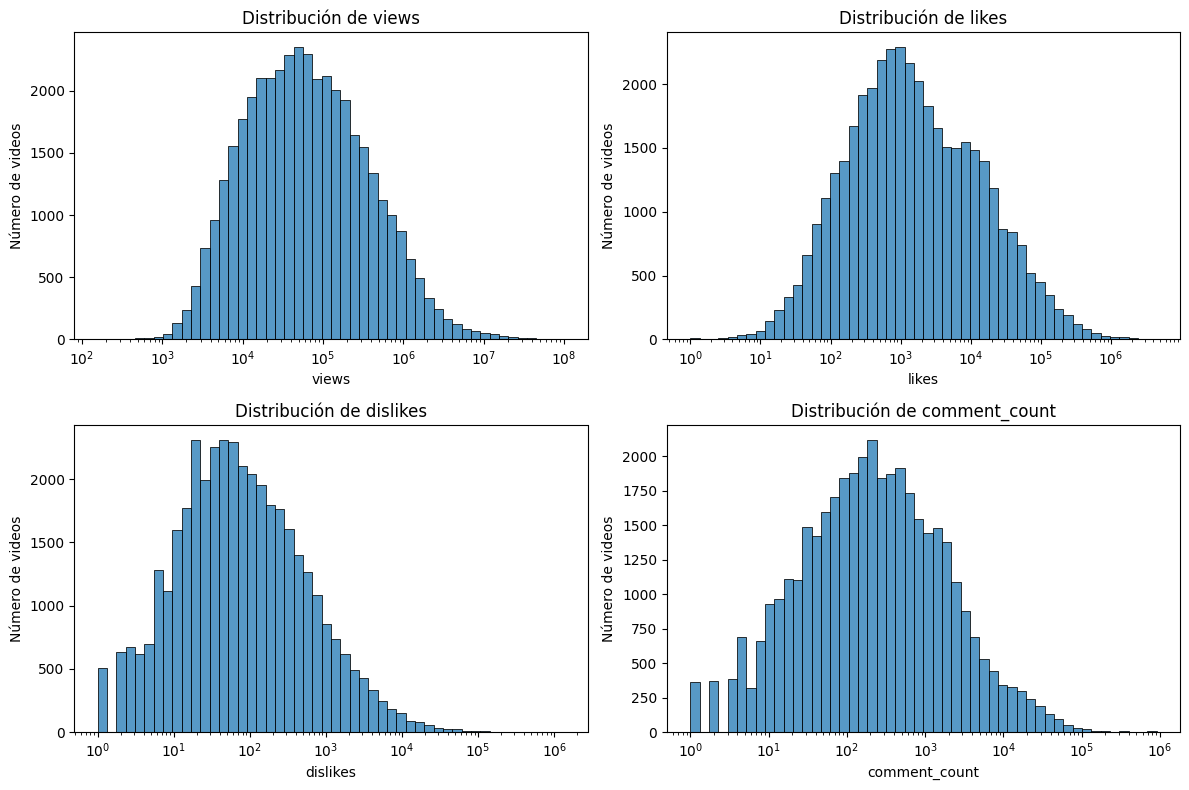

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["views", "likes", "dislikes", "comment_count"]

plt.figure(figsize=(12,8))

for i, col in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=50, log_scale=(True, False))  
    # log_scale=(True, False) -> log en X, lineal en Y
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Número de videos")

plt.tight_layout()
plt.show()

### Revisar valores duplicados para decidir cómo eliminarlos 

El objetivo es analizar videos únicos.

La fila con más vistas (representa el impacto máximo del video). Eliminaremos los repetidos conservando la instancia con mayor cantidad de vistas.

In [6]:
total_filas= df.shape[0]

# Cuántos video_id están duplicados (excluyendo la primera ocurrencia)
num_duplicados = df["video_id"].duplicated().sum()

# Porcentaje de duplicados
porcentaje_duplicados = (num_duplicados / total_filas) * 100

print(f"Video_id duplicados: {num_duplicados}")
print(f"Porcentaje de duplicados: {porcentaje_duplicados:.2f}%")

Video_id duplicados: 6938
Porcentaje de duplicados: 17.15%


In [7]:
# Ver algunos ejemplos de video_id duplicados
duplicados = df["video_id"].value_counts()
duplicados = duplicados[duplicados > 1]   # quedarnos solo con los repetidos

# Mostrar los 10 primeros duplicados como ejemplo
print(duplicados.head(10))

video_id
#NAME?         516
Grq_h8S_UlE      4
aJOTlE1K90k      4
bTsf8w4wVy4      4
tIDH8s7PSrk      4
ezcKDkH1OZc      4
nI1YOQxJIHs      4
qG7gw5oaG9Y      4
_I_D_8Z4sJE      4
wjbRpr7qX38      4
Name: count, dtype: int64


In [8]:
conteo_por_categoria = df['category_id'].value_counts()

print(conteo_por_categoria)

category_id
24    13487
22     8159
17     4050
10     3371
25     3113
26     2467
23     1742
1      1298
20      994
27      532
28      531
2       252
29      252
19      117
15       83
43        3
Name: count, dtype: int64


In [9]:
num_categorias = df['category_id'].nunique()
print("Número de categorías distintas:", num_categorias)

categorias_distintas = df['category_id'].unique()
print("Categorías distintas:", categorias_distintas)

Número de categorías distintas: 16
Categorías distintas: [24 22 25 26 10 23 17  2  1 29 27 28 20 15 19 43]


# ETL (Transform)

### Identificar y eliminar valores duplicados

In [10]:
# Ordenar los valores de forma descendente
df_sorted = df.sort_values(by='views', ascending=False)

# Eliminar los valores duplicados manteniendo la primera instanciai
df_sin_duplicados = df_sorted.drop_duplicates(subset='video_id', keep='first')

print(f"Número de filas original: {df.shape[0]}")
print(f"Número de filas después de eliminar duplicados: {df_sin_duplicados.shape[0]}")

Número de filas original: 40451
Número de filas después de eliminar duplicados: 33513


In [11]:
duplicados = df["video_id"].value_counts()
print(duplicados)

video_id
#NAME?         516
Grq_h8S_UlE      4
aJOTlE1K90k      4
bTsf8w4wVy4      4
tIDH8s7PSrk      4
              ... 
dyIdtyAAf9o      1
ryFff8fsjWc      1
faOm-j2-4Q4      1
D6u0KccfK6I      1
dj5Z4jTE3-c      1
Name: count, Length: 33513, dtype: int64


### Filtramos las columnas que vamos a ocupar

Se decidió eliminar las columnas video_id, title, channel_title, tags, description y thumbnail_link porque no aportan información numérica relevante para el análisis de tendencias ni para un modelo de regresión. Estas variables son principalmente identificadores, texto libre o enlaces, lo cual complica su uso en un enfoque estadístico y podría introducir ruido. Al conservar únicamente variables cuantitativas y categóricas útiles, se simplifica el dataset y se prepara una base más limpia y enfocada para el análisis exploratorio y predictivo.

In [12]:
columns_to_drop = ['video_id', 'title', 'channel_title', 'tags', 'description', 'thumbnail_link']
df_cleaned = df.drop(columns=columns_to_drop)

display(df_cleaned.head())

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
0,17.14.11,24,2017-11-13T06:06:22.000Z,310130,4182,361,1836,False,False,False
1,17.14.11,22,2017-11-13T05:11:58.000Z,104972,271,174,369,False,False,False
2,17.14.11,25,2017-11-13T17:00:02.000Z,136064,10105,266,607,False,False,False
3,17.14.11,25,2017-11-13T03:47:10.000Z,96153,378,171,208,False,False,False
4,17.14.11,26,2017-11-13T19:17:48.000Z,499965,57781,681,7428,False,False,False


### Identificar si hay celdas vacías

Identificamos si después de filtrar las columnas, existen celdas vacías que afecten nuestras variables de hipótesis. De ser así, eliminarlas si y solo si no representan un garn porcentaje de nuestros datos a trabajar y estudiar.

In [13]:
# Contar valores nulos por columna
print(df_cleaned.isnull().sum())

trending_date             0
category_id               0
publish_time              0
views                     0
likes                     0
dislikes                  0
comment_count             0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
dtype: int64


In [14]:
# Selecciona solo columnas numéricas
numeric_df = df_cleaned.select_dtypes(include=["number"])

# Conteo de negativos por columna
print((numeric_df < 0).sum())

# Conteo total de negativos en todo el DF
print((numeric_df < 0).sum().sum())

category_id      0
views            0
likes            0
dislikes         0
comment_count    0
dtype: int64
0


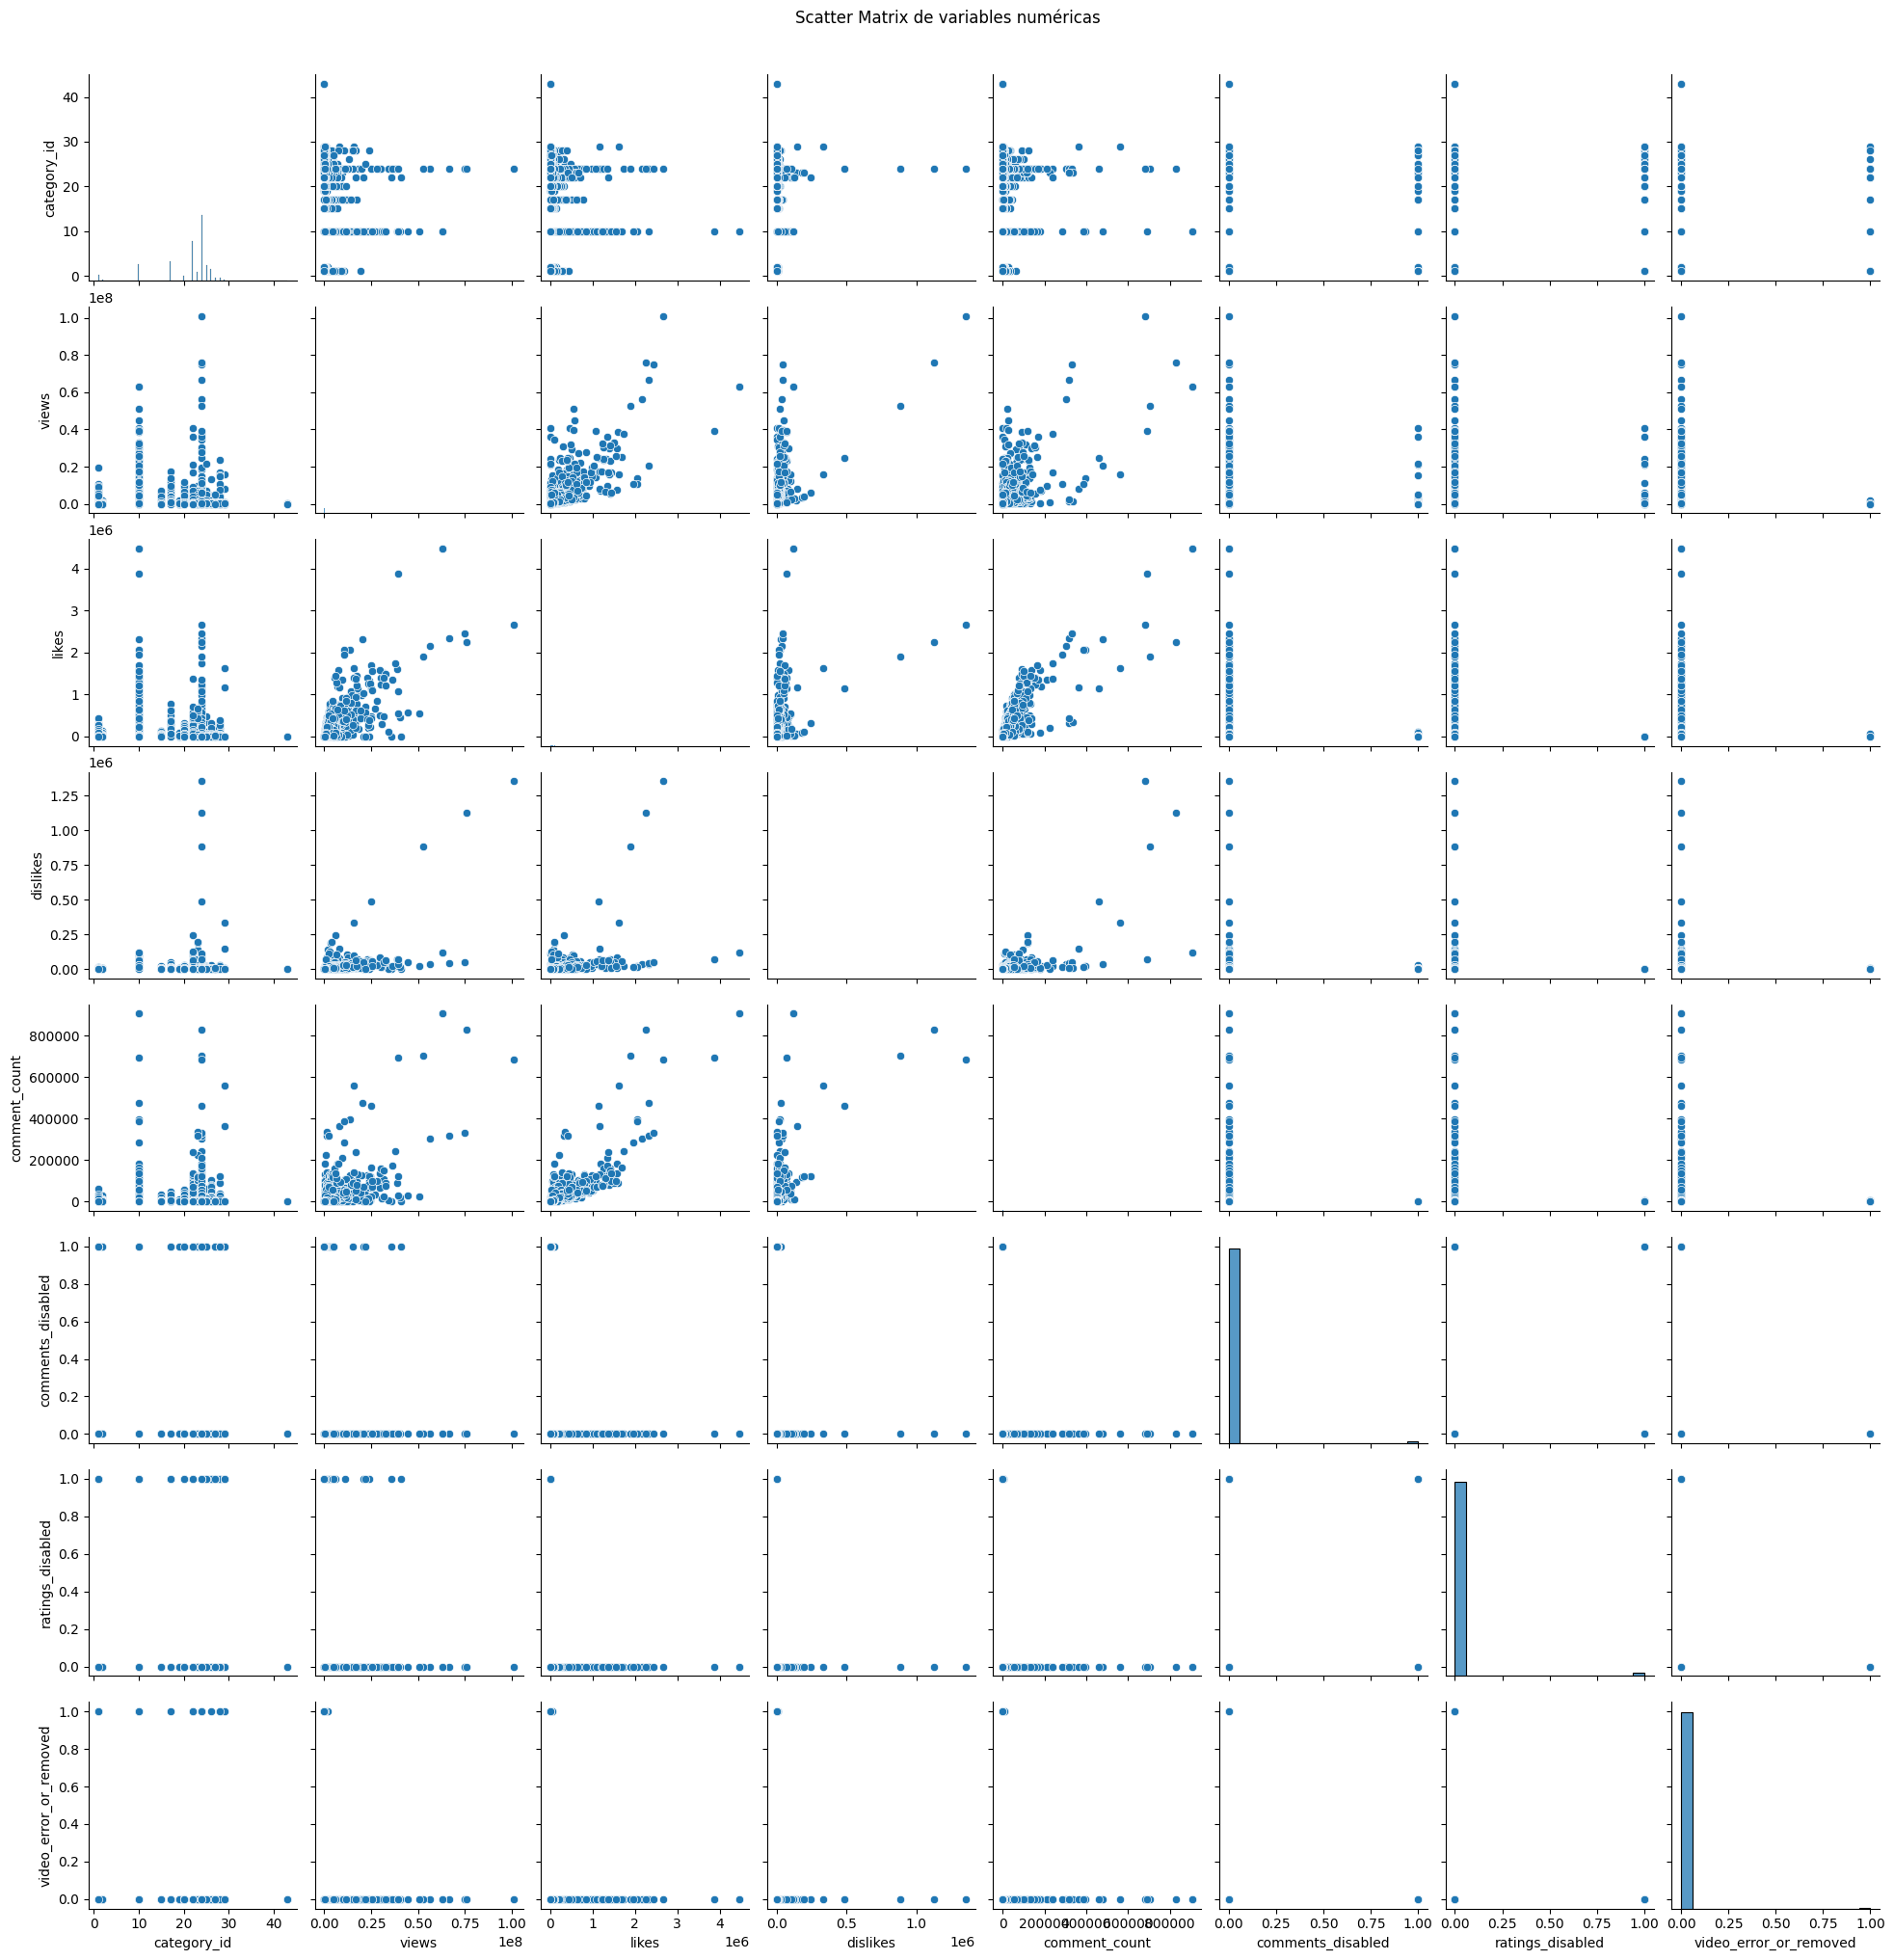

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir las columnas booleanas a enteros (0/1)
bool_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
df[bool_cols] = df[bool_cols].astype(int)

# Seleccionar solo columnas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Crear scatter matrix (pairplot)
sns.pairplot(numeric_df, diag_kind="hist")
plt.suptitle("Scatter Matrix de variables numéricas", y=1.02)
plt.show()


### Puntos más destacables:

La matriz de dispersión muestra que existe una correlación positiva clara entre views, likes y comment_count, lo que confirma que a mayor número de visualizaciones un video tiende a recibir más interacciones. También se observa que likes y dislikes están relacionados, ya que los videos con mayor alcance suelen acumular tanto reacciones positivas como negativas.

 Sin embargo, aparecen outliers muy marcados que corresponden a videos virales con valores atípicos en millones, lo cual refuerza la necesidad de tratarlos en el análisis. Por otro lado, la variable de categoría no presenta patrones evidentes con las demás métricas, y las variables booleanas (como comments_disabled o ratings_disabled) se concentran en 0, mostrando que son casos poco frecuentes y con menor peso en la tendencia general.

### Conclusión del scatterplot:

El scatter matrix confirma que views, likes y comentarios están altamente relacionados y que la popularidad en YouTube sigue un patrón lógico de mayor exposición = más interacciones. Sin embargo, la presencia de outliers muy marcados y variables categóricas poco influyentes sugiere la necesidad de aplicar técnicas de normalización y análisis robusto para obtener conclusiones más confiables.

In [16]:
df_cleaned["engagement_rate"] = (df_cleaned["likes"] + df_cleaned["comment_count"]) / df_cleaned["views"]

Esta parte del código sirve para crear y analizar la métrica de engagement rate por categoría de video en YouTube México.

Esto mide qué tanto interactúa la audiencia (likes y comentarios) en proporción a las vistas totales del video.

In [20]:
engagement_stats = df_cleaned.groupby("category_id").agg({
    "views": "mean",
    "likes": "mean",
    "dislikes": "mean",
    "comment_count": "mean",
    "engagement_rate": "mean"
}).sort_values("engagement_rate", ascending=False)

Con groupby("category_id"), se agrupan los videos por categoría y se calculan promedios de las variables numéricas principales (views, likes, dislikes, comment_count y engagement_rate). El resultado se ordena de mayor a menor según el engagement_rate.

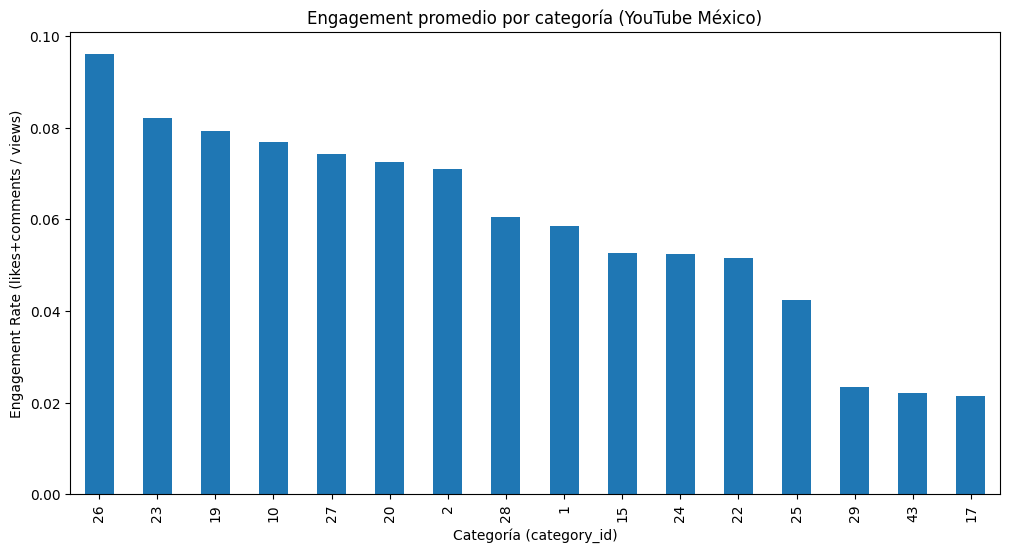

In [23]:
import matplotlib.pyplot as plt

engagement_stats["engagement_rate"].plot(kind="bar", figsize=(12,6))
plt.title("Engagement promedio por categoría (YouTube México)")
plt.ylabel("Engagement Rate (likes+comments / views)")
plt.xlabel("Categoría (category_id)")
plt.show()

Con matplotlib, se genera un gráfico de barras que muestra el engagement promedio por categoría, permitiendo identificar qué tipos de videos generan más interacción relativa con su audiencia.

## Análisis de Patrones

### Correlación: Analiza la correlación entre las variables para entender las relaciones.

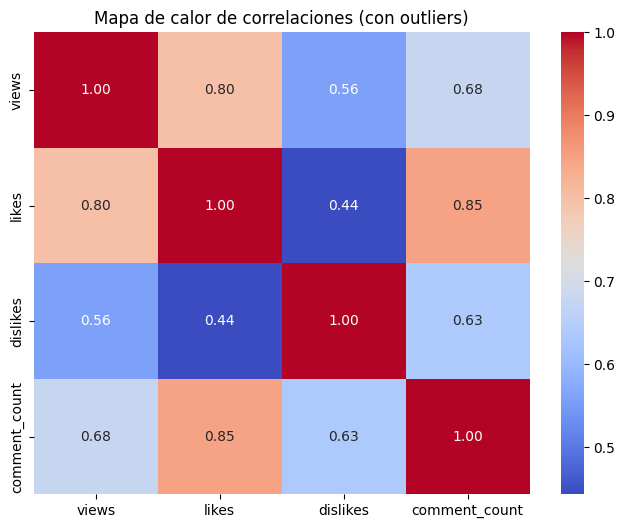

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["views", "likes", "dislikes", "comment_count"]

plt.figure(figsize=(8,6))
corr = df[cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones (con outliers)")
plt.show()


Identificación de Características Clave: Determina qué variables parecen influir más en el número de visualizaciones.

- Identificación y tratamiento de outliers

Podemos usar boxplots y el criterio de IQR (Interquartile Range) para detectar y opcionalmente filtrar valores atípicos.

Decidimos no eliminarlos, estos valores atipicos, forman parte de lo que es Yt

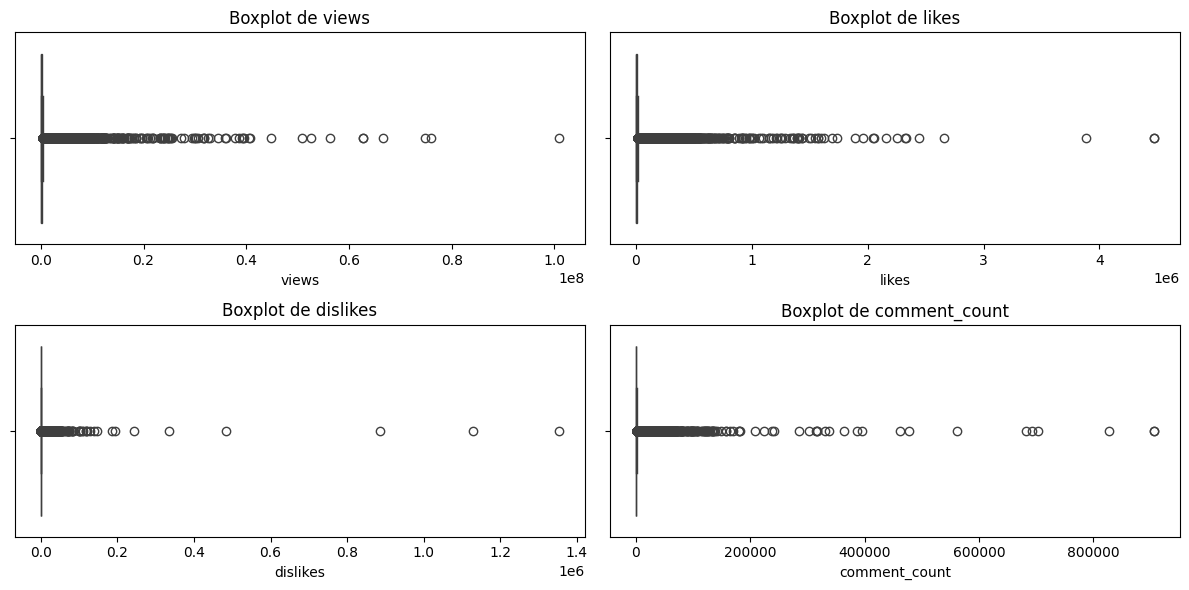

Cantidad de outliers por variable:
views            5209
likes            5783
dislikes         5618
comment_count    5447
dtype: int64
Tamaño original: (40451, 16)  -> Sin outliers: (31586, 16)


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables numéricas que nos interesan
cols = ["views", "likes", "dislikes", "comment_count"]

# Boxplots para detectar outliers
plt.figure(figsize=(12,6))
for i, col in enumerate(cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# Método IQR para detección de outliers
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).sum()
print("Cantidad de outliers por variable:")
print(outliers)

# Eliminar outliers si es necesario
df_clean = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Tamaño original:", df.shape, " -> Sin outliers:", df_clean.shape)


In [32]:
df_cleaned.head()

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,engagement_rate
0,17.14.11,24,2017-11-13T06:06:22.000Z,310130,4182,361,1836,False,False,False,0.019405
1,17.14.11,22,2017-11-13T05:11:58.000Z,104972,271,174,369,False,False,False,0.006097
2,17.14.11,25,2017-11-13T17:00:02.000Z,136064,10105,266,607,False,False,False,0.078728
3,17.14.11,25,2017-11-13T03:47:10.000Z,96153,378,171,208,False,False,False,0.006094
4,17.14.11,26,2017-11-13T19:17:48.000Z,499965,57781,681,7428,False,False,False,0.130427


## Hot encoding

En nuestro dataset tenemos la columna category_id, que nos dice el tipo de video que es. Como es una variable cualitativa realizamos un hot encoding para poder tratarla como un valor cuantitativo cuando entrenemos nuestro modelo.

In [35]:
category_map = {
    "1": "Film & Animation",
    "2": "Autos & Vehicles",
    "10": "Music",
    "15": "Pets & Animals",
    "17": "Sports",
    "18": "Short Movies",
    "19": "Travel & Events",
    "20": "Gaming",
    "21": "Videoblogging",
    "22": "People & Blogs",
    "23": "Comedy",
    "24": "Entertainment",
    "25": "News & Politics",
    "26": "Howto & Style",
    "27": "Education",
    "28": "Science & Technology",
    "30": "Movies",
    "31": "Anime/Animation",
    "32": "Action/Adventure",
    "33": "Classics",
    "34": "Comedy",
    "35": "Documentary",
    "36": "Drama",
    "37": "Family",
    "38": "Foreign",
    "39": "Horror",
    "40": "Sci-Fi/Fantasy",
    "41": "Thriller",
    "42": "Shorts",
    "43": "Shows",
    "44": "Trailers"
}

# Mapear ids a nombres
df_cleaned['category_name'] = df_cleaned['category_id'].astype(str).map(category_map)

df_encoded = pd.get_dummies(df_cleaned, columns=['category_name'], prefix='', prefix_sep='')

df_encoded.head()

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,...,Gaming,Howto & Style,Music,News & Politics,People & Blogs,Pets & Animals,Science & Technology,Shows,Sports,Travel & Events
0,17.14.11,24,2017-11-13T06:06:22.000Z,310130,4182,361,1836,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,17.14.11,22,2017-11-13T05:11:58.000Z,104972,271,174,369,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,17.14.11,25,2017-11-13T17:00:02.000Z,136064,10105,266,607,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,17.14.11,25,2017-11-13T03:47:10.000Z,96153,378,171,208,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,17.14.11,26,2017-11-13T19:17:48.000Z,499965,57781,681,7428,False,False,False,...,False,True,False,False,False,False,False,False,False,False
